In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:

def imshow(img,size=None,unnorm=False):
    if unnorm:
      img = img*0.5 + 0.5     
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    return None

def show(G,z=None,batch_size=128,nz=100,vae=False):
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16),unnorm=(not vae))
    return(pil_img)
  

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



In [3]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root="./data_mnist", train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [4]:
nz = 100

ngf, ndf = 64, 64

class GeneratorMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class DiscriminatorMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels = ndf * 4, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )
        self.fc = nn.Linear(128, 1)

    def forward(self, input, return_features=False):
        x = self.main(input)
        x = x.view(-1, 128)
        y = nn.LeakyReLU(0.2, inplace=True)(x)
        y = self.fc(y)
        y = nn.Sigmoid()(y)
        if return_features:
            return x, y
        return y

In [5]:

# def imshow(img,size=None,unnorm=False):
#     if unnorm:
#       img = img*0.5 + 0.5     
#     if size is not None:
#       img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
#     pil_img = torchvision.transforms.functional.to_pil_image(img)
#     display(pil_img)
#     return None

# def show(G,z=None,batch_size=128,nz=100,vae=False):
#   with torch.no_grad():
#     if z==None:
#       z = torch.randn(batch_size,nz,1,1).to(device)
#     genimages = G(z)
#     pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16),unnorm=(not vae))
#     return(pil_img)
  

# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

# G = GeneratorMNIST().to(device)
# D = DiscriminatorMNIST().to(device)

# G.apply(weights_init);
# D.apply(weights_init);


[1/10][467/468][16.7837 s]	Loss_D: -0.9993	Loss_G: -0.0001


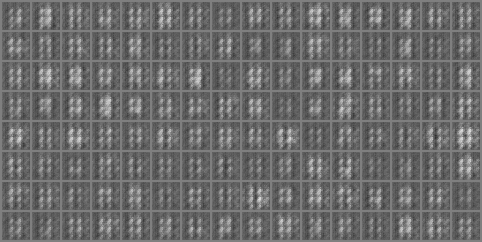

[2/10][467/468][32.4676 s]	Loss_D: 0.0000	Loss_G: -0.0000


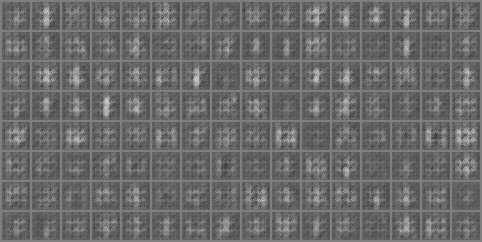

[3/10][467/468][43.5125 s]	Loss_D: 0.0000	Loss_G: -0.0000


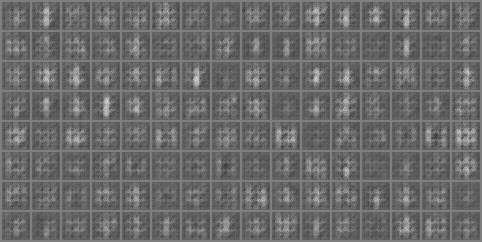

[4/10][467/468][51.3677 s]	Loss_D: 0.0000	Loss_G: -0.0000


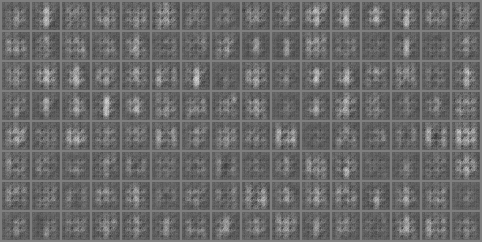

[5/10][467/468][59.2326 s]	Loss_D: 0.0000	Loss_G: -0.0000


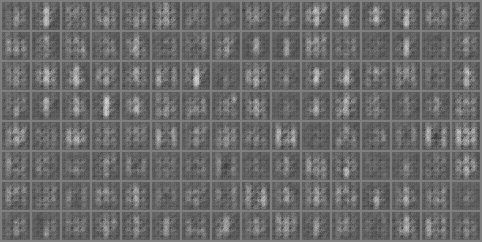

[6/10][467/468][67.1117 s]	Loss_D: 0.0000	Loss_G: -0.0000


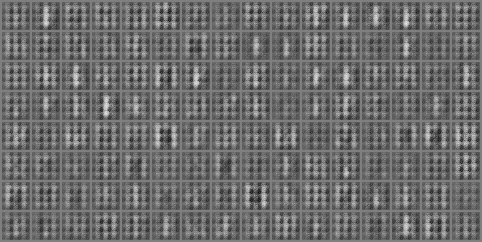

[7/10][467/468][75.0068 s]	Loss_D: 0.0000	Loss_G: -0.0000


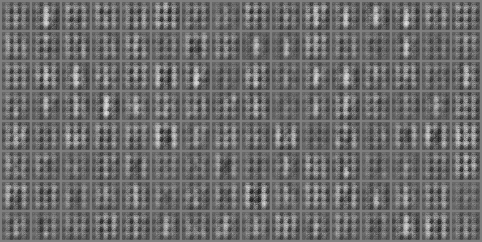

[8/10][467/468][82.9376 s]	Loss_D: 0.0000	Loss_G: -0.0000


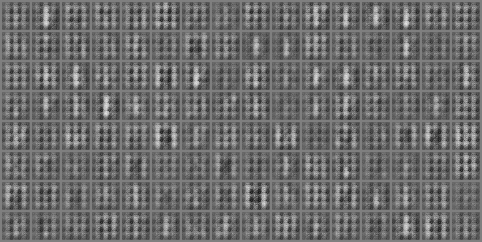

[9/10][467/468][90.8681 s]	Loss_D: 0.0000	Loss_G: -0.0000


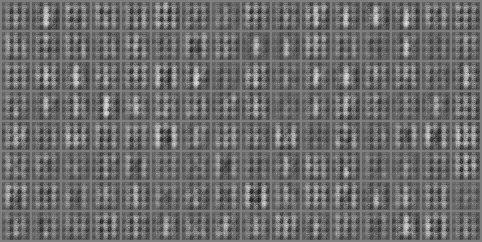

[10/10][467/468][98.8146 s]	Loss_D: 0.0000	Loss_G: -0.0000


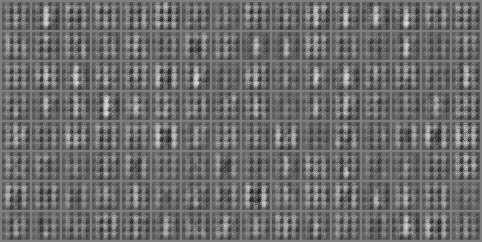

Total learning time =  98.83423972129822


In [6]:
torch.manual_seed(1)  
import time
num_epochs = 10
log_every =1
gpw = 0.1

G = GeneratorMNIST().to(device)
D = DiscriminatorMNIST().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimD = optim.SGD(D.parameters(), lr=0.03)
# optimG = optim.SGD(G.parameters(), lr=0.03)

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader, 0):


        
        real = batch[0].to(device)  
        batch_size = real.size(0)
        z = torch.randn(batch_size, nz, 1, 1, device=device) 
        faked = G(z).detach()  

       
        optimD.zero_grad()

        D_real = D(real).view(-1)
        D_fake = D(faked).view(-1)

        Dloss = -torch.mean(D_real) + torch.mean(D_fake) 

        Dloss.backward()
        optimD.step()

        optimG.zero_grad()

        z = torch.randn(batch_size, nz, 1, 1, device=device)
        faked = G(z)
        G_loss = -torch.mean(D(faked)) 
        G_loss.backward()
        optimG.step()

    if i % log_every == 0:
        print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f'
                % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), G_loss.item()))
        show(G, zviz, vae=False)

print('Total learning time = ',time.time()-t0)

In [7]:
class SWD_loss(nn.Module):
    """
    Computes the average 1D Wasserstein (Earth Mover) distance across
    multiple random projections of high-dimensional data.

    x, y are of shape (B, C, H, W). We'll flatten them to (B, D), then:
      - Sample random directions (n_projections, D)
      - Normalize each direction
      - Project x and y -> shape (B,) each, sort, take mean absolute diff
      - Average across all projections
    """
    def __init__(self, n_projections=5):
        super().__init__()
        self.n_projections = n_projections

    def forward(self, x, y):
        if len(x.shape) == 4:
            # x, y: (B, C, H, W). Flatten to (B, D)
            B, C, H, W = x.shape
            x_flat = x.view(B, -1)  # shape = (B, D)
            y_flat = y.view(B, -1)  # shape = (B, D)
        else : 
            x_flat = x
            y_flat = y
        device = x.device
        D = x_flat.shape[1]

        # Accumulate average Wasserstein distance across random projections
        wdist = 0.0
        for _ in range(self.n_projections):
            # Sample random direction vector
            direction = torch.randn(D, device=device)
            # Normalize to unit length
            direction = direction / (direction.norm(p=2) + 1e-8)

            # Project onto this direction => shape (B,)
            x_proj = x_flat @ direction
            y_proj = y_flat @ direction

            # Sort
            x_sorted, _ = torch.sort(x_proj)
            y_sorted, _ = torch.sort(y_proj)

            # 1D Wasserstein distance: mean of |sorted(x) - sorted(y)|
            wdist += torch.mean(torch.abs(x_sorted - y_sorted))

        return wdist / self.n_projections

[1/10][467/468][15.0428 s]	Loss_D: -0.4905	Loss_G: 0.6431


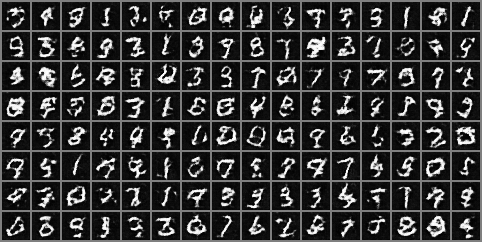

[2/10][467/468][30.2601 s]	Loss_D: -0.5302	Loss_G: 0.4329


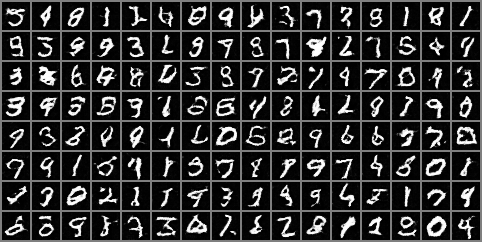

[3/10][467/468][45.7300 s]	Loss_D: -0.4029	Loss_G: 0.4236


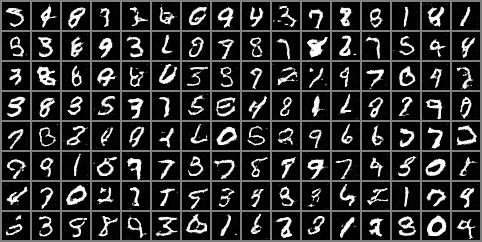

[4/10][467/468][61.0889 s]	Loss_D: -0.2866	Loss_G: 0.3611


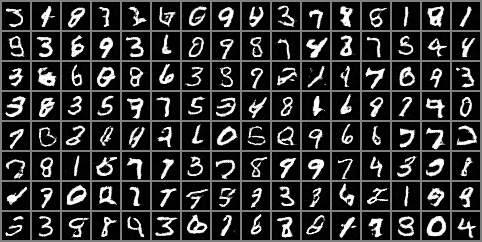

[5/10][467/468][76.6042 s]	Loss_D: -0.2380	Loss_G: 0.3366


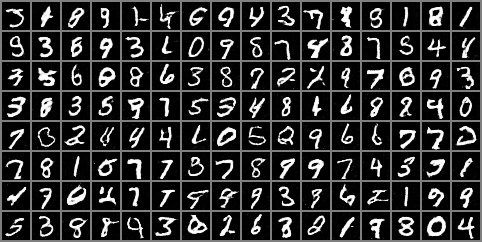

[6/10][467/468][92.0885 s]	Loss_D: -0.2332	Loss_G: 0.2994


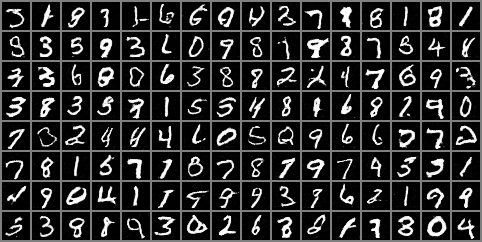

[7/10][467/468][107.5801 s]	Loss_D: -0.2494	Loss_G: 0.3269


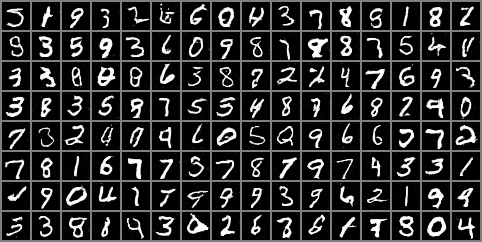

[8/10][467/468][123.0782 s]	Loss_D: -0.2917	Loss_G: 0.2994


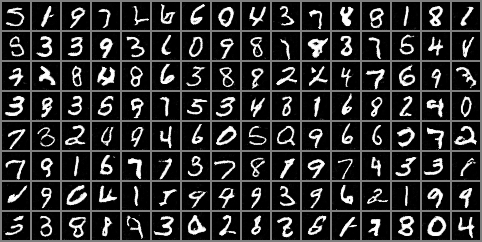

[9/10][467/468][138.6080 s]	Loss_D: 0.0003	Loss_G: 0.1511


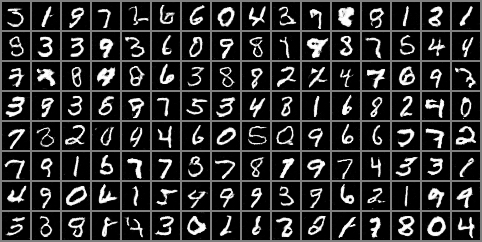

[10/10][467/468][153.9605 s]	Loss_D: -0.1326	Loss_G: 0.3604


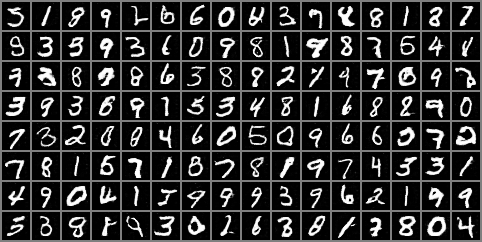

Total learning time =  153.97233772277832


In [8]:
torch.manual_seed(1)  
import time
num_epochs = 10
log_every = 1
gpw = 0.1

G = GeneratorMNIST().to(device)
D = DiscriminatorMNIST().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimD = optim.SGD(D.parameters(), lr=0.02)
# optimG = optim.SGD(G.parameters(), lr=0.02)
zviz = torch.randn(batch_size,nz,1,1).to(device)
swd_loss = SWD_loss(n_projections=50)


t0 = time.time()
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader, 0):


        
        real = batch[0].to(device)  
        batch_size = real.size(0)
        z = torch.randn(batch_size, nz, 1, 1, device=device) 
        faked = G(z).detach()  

       
        optimD.zero_grad()

        D_real_int, D_real = D(real, return_features=True)
        D_fake_int, D_fake = D(faked, return_features=True)

        Dloss = -torch.mean(D_real) + torch.mean(D_fake) 

        Dloss.backward()
        optimD.step()

        with torch.no_grad():
            real = batch[0].to(device)  
            D_real_int, D_real = D(real, return_features=True)
        
        optimG.zero_grad()
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        faked = G(z)
        D_fake_int, D_fake = D(faked, return_features=True)
        G_loss = swd_loss(D_real_int, D_fake_int)
        G_loss.backward()
        optimG.step()

    if i % log_every == 0:
        print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f'
                % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), G_loss.item()))
        show(G, zviz, vae=False)

print('Total learning time = ',time.time()-t0)